In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

### emoji to text to bert embedding 

In [55]:
def getdfs(data : str, train_size : float = 1):
    '''
    preprocess and return train_df and val_df
    '''
    if data not in ['text_seq', 'feature' , 'emoticon']:
        raise ValueError("Invalid data type")
    
    if data == 'feature' : 
        train_df = np.load(f"/Users/siya/Desktop/datasets/train/train_{data}.npz") #for my laptop
        valid_df = np.load(f"/Users/siya/Desktop/datasets/valid/valid_{data}.npz")
    else :
        train_df = pd.read_csv(f"/Users/siya/Desktop/datasets/train/train_{data}.csv")
        val_df = pd.read_csv(f"/Users/siya/Desktop/datasets/valid/valid_{data}.csv")
    
    train_df = train_df[:int(len(train_df)*train_size)]

    def get_char_columns(df):
        for i in range(len(df['input_emoticon'][0])):
            df[f'c_{i+1}'] = df['input_emoticon'].apply(lambda x, _i=i: x[_i])
        
        return df[df.columns.to_list()[2:] + ['label']]

    if data == 'emoticon':
        train_df = get_char_columns(train_df)
        val_df = get_char_columns(val_df)

    return train_df, val_df

In [56]:

from transformers import AutoTokenizer, AutoModel
import torch
import demoji

train_df, val_df = getdfs('emoticon')

for i in range(13) :
    train_df[f'c_{i+1}_text'] = train_df[f'c_{i+1}'].apply(lambda x: demoji.replace_with_desc(x)[1:-1] if x != '' else x)
    val_df[f'c_{i+1}_text'] = val_df[f'c_{i+1}'].apply(lambda x: demoji.replace_with_desc(x)[1:-1] if x != '' else x)


tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

def text2embed(text) :
    inputs = tokenizer(text, return_tensors='pt')
    
    with torch.no_grad():
        outputs = model(**inputs)
        
    embeddings = outputs.last_hidden_state
    sentence_embedding = torch.mean(embeddings, dim=1)

    return sentence_embedding.numpy().reshape(-1)

texts = []
for i in range(13) :
    for text in train_df[f'c_{i+1}_text'] :
        texts.append(text)
texts = list(set(texts))

dict_text2bed = {f'{text}' : text2embed(text) for text in texts}

def embed_df(df : pd.DataFrame, embedding_dim : int = 768, num_columns: int = 13)-> pd.DataFrame :

    # Initialize a list to store rows of combined embeddings
    combined_embeddings = []

    # Iterate over each row in the dataframe
    for idx, row in df.iterrows():
        row_embeddings = []
        
        # Iterate over the 13 columns and get the embedding for each
        for i in range(num_columns):
            column_text = row[f'c_{i+1}_text']
            
            # If the text is not empty, fetch its embedding, else use a zero vector
            if column_text != '':
                embedding = dict_text2bed.get(column_text, np.zeros(embedding_dim))
            else:
                embedding = np.zeros(embedding_dim)
            
            # Append the embedding to the row list
            row_embeddings.append(embedding)
        
        # Concatenate the embeddings for the row
        combined_embeddings.append(np.hstack(row_embeddings))

    # Convert the list of rows into a NumPy array
    X = np.vstack(combined_embeddings)
    
    return X

train_X1 = embed_df(train_df)
train_Y1 = train_df['label']

valid_X1 = embed_df(val_df)
valid_Y1 = val_df['label']

In [57]:
# Read feature dataset
train_feat = np.load("/Users/siya/Desktop/datasets/train/train_feature.npz", allow_pickle=True)
val_feat = np.load("/Users/siya/Desktop/datasets/valid/valid_feature.npz", allow_pickle=True)
train_X2 = train_feat['features']
train_Y2 = train_feat['label']
valid_X2 = val_feat['features']
valid_Y2 = val_feat['label']

In [58]:
train_X2 = train_X2.reshape(7080, -1)
print(train_X2.shape)

valid_X2 = valid_X2.reshape(489, -1)
print(valid_X2.shape)

(7080, 9984)
(489, 9984)


In [59]:
train_X1.shape

(7080, 9984)

In [60]:
train_X2 = train_X2.reshape(7080, -1)
print(train_X2.shape)

(7080, 9984)


In [61]:
valid_X2 = valid_X2.reshape(489, -1)
print(valid_X2.shape)

(489, 9984)


### Linear Regression 

In [62]:
model = LinearRegression()
model.fit(train_X1, train_X2)

# Check the R^2 score for the prediction
r2_score = model.score(train_X1, train_X2)
print(f"R^2 score: {r2_score}")


R^2 score: 0.9501838798419456


In [63]:
model2 = LinearRegression()
model2.fit(valid_X1, valid_X2)

# Check the R^2 score for the prediction
r2_score = model2.score(valid_X1, valid_X2)
print(f"R^2 score: {r2_score}")


R^2 score: 1.0


In [75]:
predictions = model.predict(train_X1)
print("First 5 Actual values of train_feat_X2:\n", train_X2[:5])
print("First 5 Predicted values:\n", predictions[:5])


First 5 Actual values of train_feat_X2:
 [[-0.06862289 -0.02029774  0.06447055 ... -0.02888818  0.01680396
   0.08289439]
 [-0.06862289 -0.02029774  0.06447055 ...  0.14048833 -0.02094931
  -0.00344788]
 [-0.06862289 -0.02029774  0.06447055 ...  0.04369658 -0.00869946
   0.00046251]
 [-0.06862289 -0.02029774  0.06447055 ... -0.05947836  0.08291107
  -0.02483253]
 [-0.06862289 -0.02029774  0.06447055 ...  0.14048833 -0.02094931
  -0.00344788]]
First 5 Predicted values:
 [[-0.06862289 -0.02029774  0.06447055 ... -0.05444527  0.02497864
   0.07116699]
 [-0.06862289 -0.02029774  0.06447055 ...  0.15086365 -0.00799561
   0.00744629]
 [-0.06862289 -0.02029774  0.06447055 ...  0.0477829  -0.00387573
  -0.0171814 ]
 [-0.06862289 -0.02029774  0.06447055 ...  0.02016449  0.045578
  -0.02502441]
 [-0.06862289 -0.02029774  0.06447055 ...  0.11522293 -0.00656128
  -0.01596069]]


In [76]:
predictions_val = model2.predict(valid_X1)
print("First 5 Actual values of train_feat_X2:\n", valid_X2[:5])
print("First 5 Predicted values:\n", predictions_val[:5])

First 5 Actual values of train_feat_X2:
 [[-0.06862289 -0.02029774  0.06447055 ... -0.01089599  0.00105733
  -0.03477021]
 [-0.06862289 -0.02029774  0.06447055 ... -0.09369107  0.16246203
  -0.10867456]
 [-0.06862289 -0.02029774  0.06447055 ...  0.08100505 -0.04182076
   0.1194331 ]
 [-0.06862289 -0.02029774  0.06447055 ... -0.02888818  0.01680396
   0.08289439]
 [-0.06862289 -0.02029774  0.06447055 ... -0.09709942  0.23405814
  -0.17397732]]
First 5 Predicted values:
 [[-0.06862289 -0.02029774  0.06447055 ... -0.01089599  0.00105733
  -0.03477021]
 [-0.06862289 -0.02029774  0.06447055 ... -0.09369107  0.16246203
  -0.10867456]
 [-0.06862289 -0.02029774  0.06447055 ...  0.08100505 -0.04182076
   0.1194331 ]
 [-0.06862289 -0.02029774  0.06447055 ... -0.02888818  0.01680396
   0.08289439]
 [-0.06862289 -0.02029774  0.06447055 ... -0.09709942  0.23405814
  -0.17397732]]


### Analysis 

In [77]:
# for training data 
coefficients = model.coef_
intercept = model.intercept_
print("Coefficients:", coefficients)
print("Intercept:", intercept)


Coefficients: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-6.40641328e+10  3.31636862e+10 -2.10190165e+10 ... -1.71228638e+09
  -1.49767322e+08 -5.81321431e+09]
 [ 6.40261168e+09  5.73462636e+10 -6.93818561e+10 ...  3.49512293e+08
  -6.93609359e+09  9.80095734e+08]
 [-3.78052007e+10 -6.15694696e+10  3.76687789e+10 ... -1.56269726e+09
   4.23913481e+09  2.07503420e+09]]
Intercept: [-6.86228946e-02 -2.02977415e-02  6.44705519e-02 ...  1.44147160e+10
 -1.03533136e+11  2.47739954e+11]


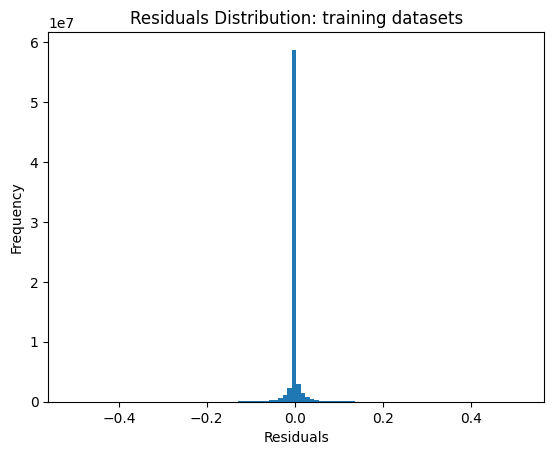

In [81]:
residuals = train_X2 - predictions
plt.hist(residuals.flatten(), bins=100)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution: training datasets')
plt.show()


In [82]:
# for validation data
coefficients2 = model2.coef_
intercept2 = model2.intercept_
print("Coefficients:", coefficients2)
print("Intercept:", intercept2)

Coefficients: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-1.07101431e-03 -3.47938470e-05  7.96323788e-06 ... -2.27693028e-03
   7.20100649e-03  2.14141465e-03]
 [-5.59978505e-03  3.82362447e-03  5.90428939e-03 ... -2.39588265e-03
  -1.13810437e-03 -2.11161033e-04]
 [ 9.67243050e-03  9.99236874e-03 -3.77638633e-03 ...  1.57160569e-03
  -6.49148049e-04 -4.87170514e-04]]
Intercept: [-0.06862289 -0.02029774  0.06447055 ...  0.00108872  0.08521018
  0.0110738 ]


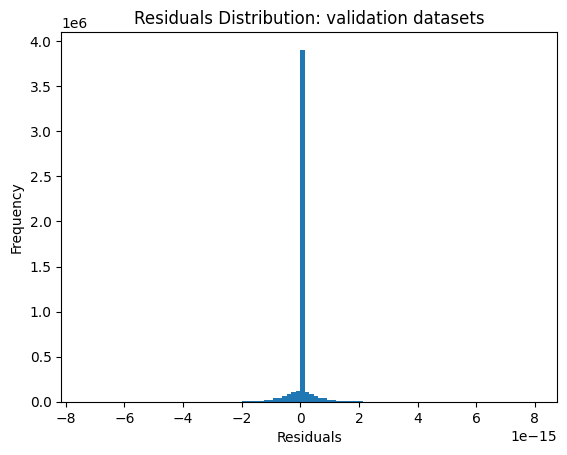

In [83]:
residuals2 = valid_X2 - predictions_val
plt.hist(residuals2.flatten(), bins=100)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution: validation datasets')
plt.show()


### Logistic Regression 

Accuracy: 95.09%


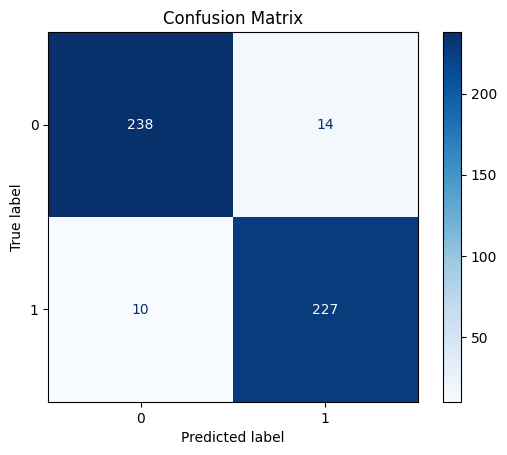

In [66]:
y_pred_lr = LogisticRegression(max_iter=1000, random_state=42)
y_pred_lr.fit(predictions, train_Y1)


# Make predictions using the logistic regression model
predictions = y_pred_lr.predict(predictions_val)

# Calculate accuracy
accuracy = accuracy_score(valid_Y1, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Compute and plot the confusion matrix
conf_matrix = confusion_matrix(valid_Y1, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


total trainable parameters: 29,955